In [15]:
import pandas as pd
import numpy as np

data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
target = raw_df.values[1::2, 2]

x = data
y = target

<>:5: SyntaxWarning: invalid escape sequence '\s'
<>:5: SyntaxWarning: invalid escape sequence '\s'
C:\Users\andre\AppData\Local\Temp\ipykernel_5336\1615212929.py:5: SyntaxWarning: invalid escape sequence '\s'
  raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)


In [19]:
columnas = [
    "CRIM", "ZN", "INDUS", "CHAS", "NOX", "RM", "AGE",
    "DIS", "RAD", "TAX", "PTRATIO", "B", "LSTAT"
]
df = pd.DataFrame(x, columns=columnas)
df['MEDV'] = y  # Agregar la variable objetivo


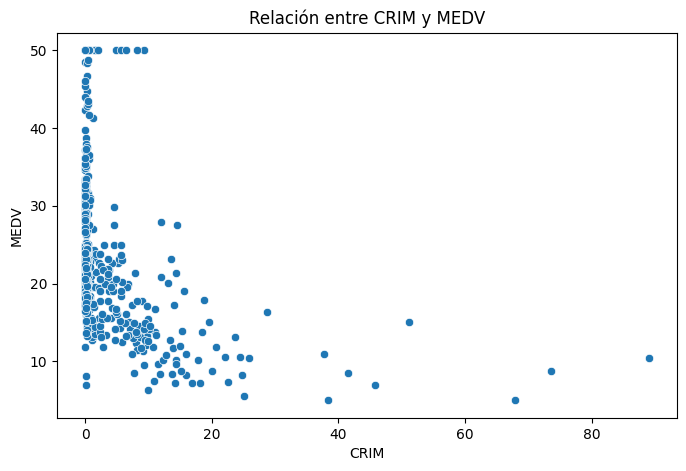

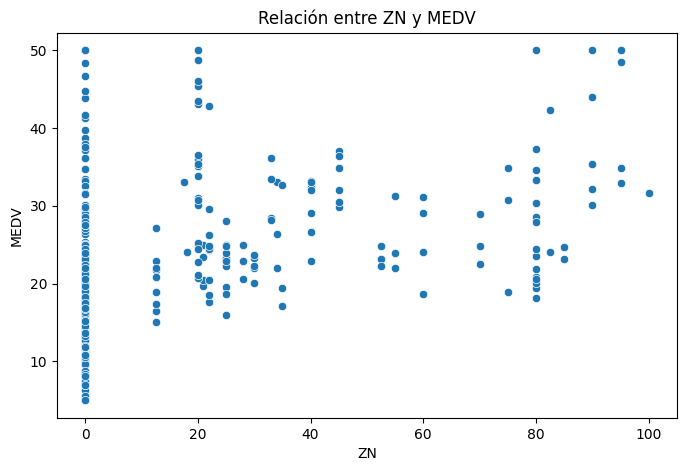

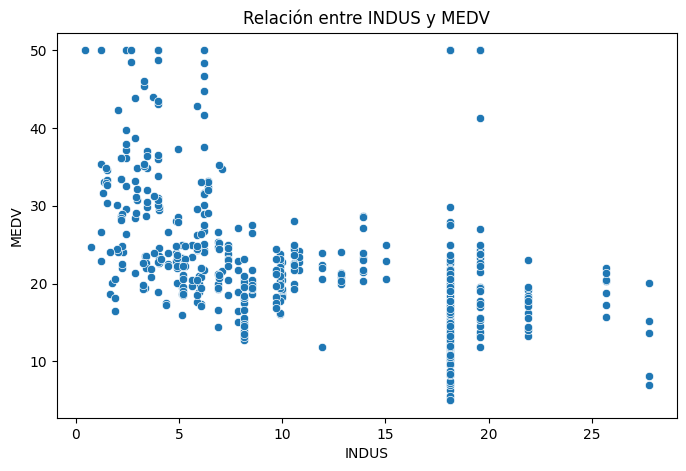

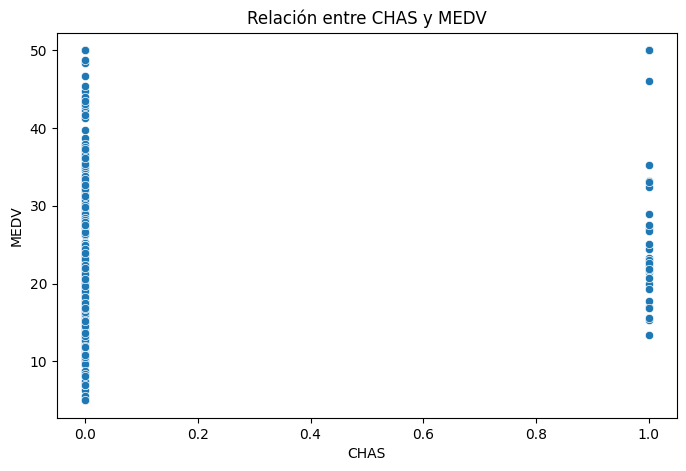

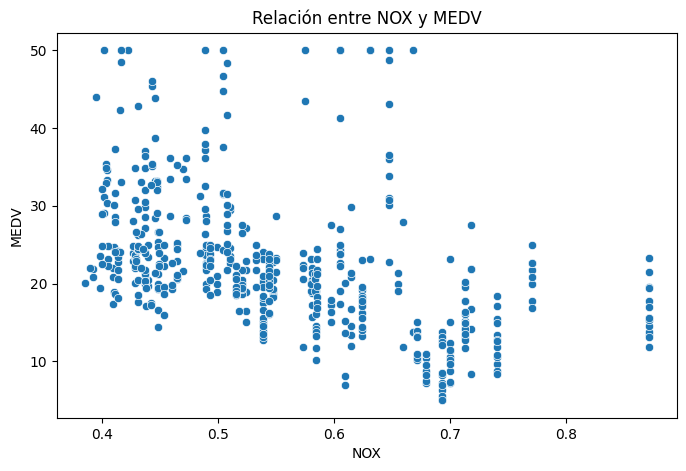

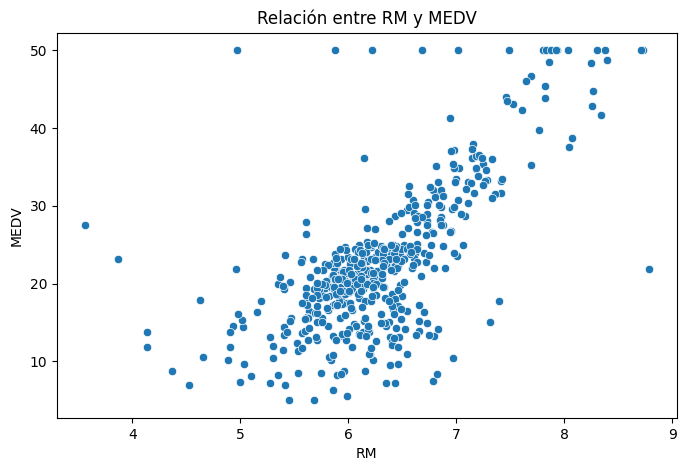

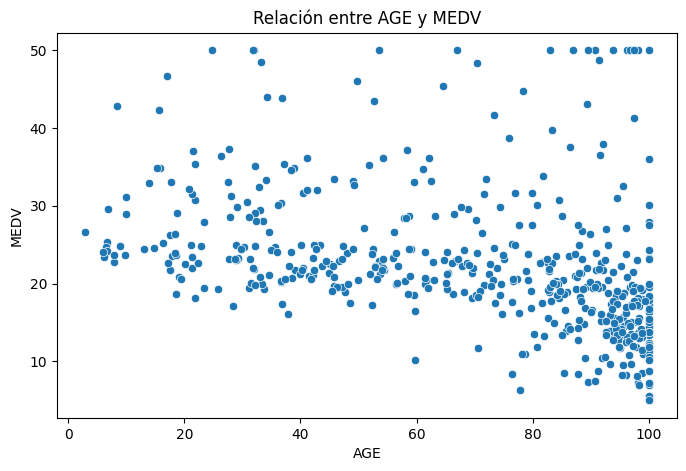

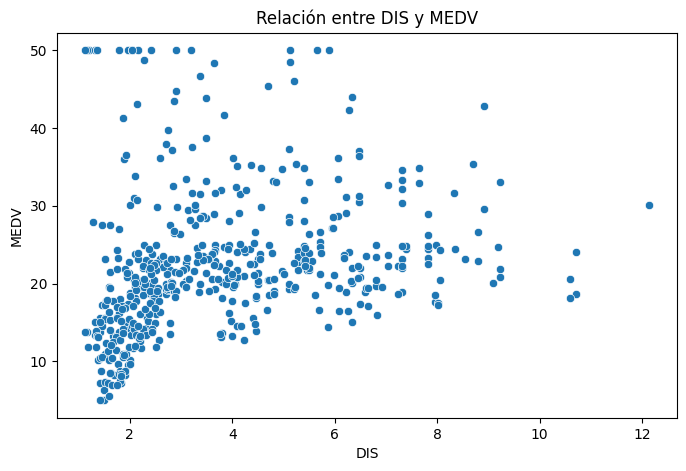

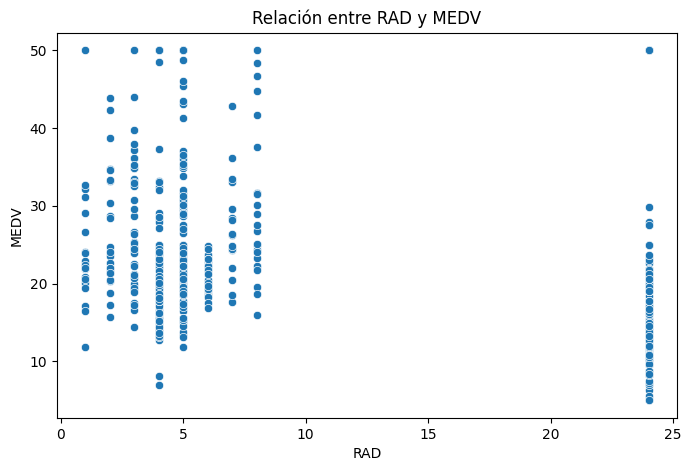

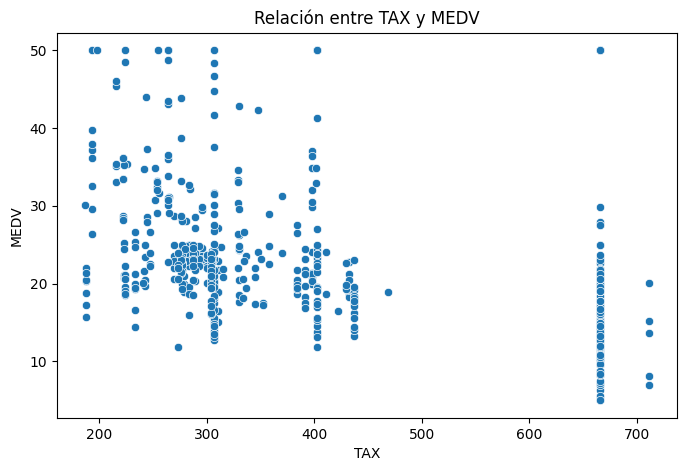

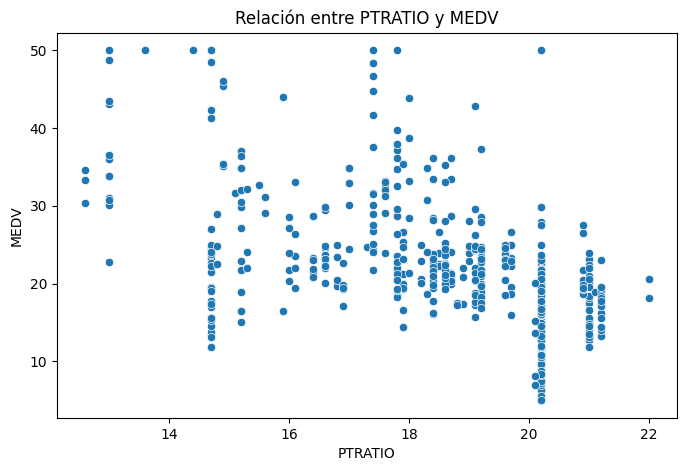

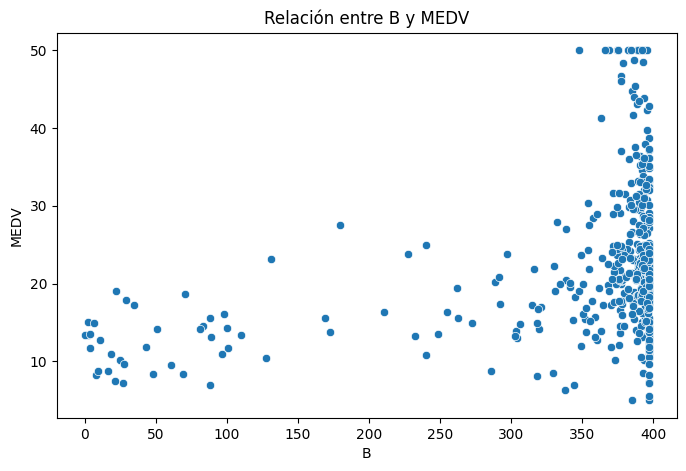

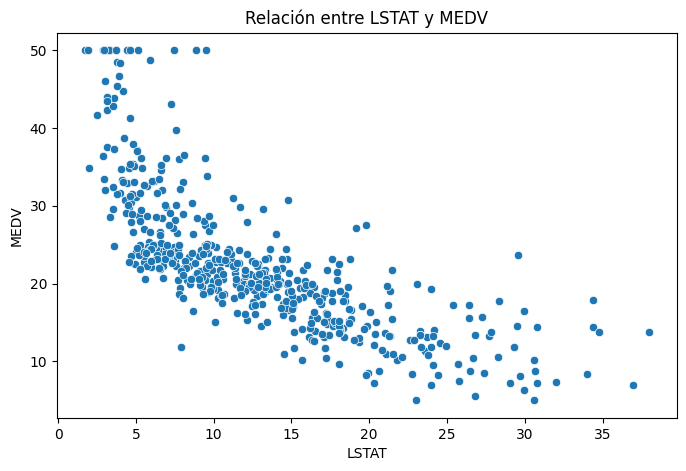

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

for col in columnas:
    plt.figure(figsize=(8,5))
    sns.scatterplot(x=df[col], y=df["MEDV"])
    plt.title(f"Relación entre {col} y MEDV")
    plt.xlabel(col)
    plt.ylabel("MEDV")
    plt.show()

In [21]:
correlaciones = df.corr()["MEDV"].sort_values(ascending=False)
print(correlaciones)

MEDV       1.000000
RM         0.695360
ZN         0.360445
B          0.333461
DIS        0.249929
CHAS       0.175260
AGE       -0.376955
RAD       -0.381626
CRIM      -0.388305
NOX       -0.427321
TAX       -0.468536
INDUS     -0.483725
PTRATIO   -0.507787
LSTAT     -0.737663
Name: MEDV, dtype: float64


In [ ]:
#a) Modelo lineal gaussiano

In [ ]:
import statsmodels.api as sm
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error

splitter = ShuffleSplit(n_splits=50, test_size=0.3, random_state=42)

mae_scores_mlg, rmse_scores_mlg = [], []

for train_index, test_index in splitter.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    X_train_sm = sm.add_constant(X_train, has_constant='add')
    X_test_sm = sm.add_constant(X_test, has_constant='add')

    model_gaussian = sm.GLM(y_train, X_train_sm, family=sm.families.Gaussian())
    fitted = model_gaussian.fit()

    y_pred_gaussian = fitted.predict(X_test_sm)

    mae_scores_mlg.append(mean_absolute_error(y_test, y_pred_gaussian))
    rmse_scores_mlg.append(mean_squared_error(y_test, y_pred_gaussian) ** 0.5)


mae_median = np.median(mae_scores_mlg)
mae_std = np.std(mae_scores_mlg, ddof=1)
rmse_median = np.median(rmse_scores_mlg)
rmse_std = np.std(rmse_scores_mlg, ddof=1)

print(f"Gaussian Model – MAE: {mae_median:.2f} ± {mae_std:.2f}")
print(f"Gaussian Model – RMSE: {rmse_median:.2f} ± {rmse_std:.2f}")


Gaussian Model – MAE: 3.39 ± 0.22
Gaussian Model – RMSE: 4.91 ± 0.45


In [11]:
#b) Modelo lineal con regularización Elastic Net

In [46]:
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import ShuffleSplit, GridSearchCV, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

param_grid = {
    "elastic__alpha": [0.001, 0.01, 0.1, 1, 10],
    "elastic__l1_ratio": [0.1, 0.3, 0.5, 0.7, 0.9, 0.99],
}

pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("elastic", ElasticNet(max_iter=5000, random_state=42))
])

inner_cv = KFold(n_splits=7, shuffle=True, random_state=42)
splitter = ShuffleSplit(n_splits=50, test_size=0.3, random_state=42)

mae_scores, rmse_scores = [], []

for train_idx, test_idx in splitter.split(X):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    grid = GridSearchCV(
        pipeline,
        param_grid,
        scoring="neg_mean_squared_error",
        cv=inner_cv,
        n_jobs=-1
    )
    grid.fit(X_train, y_train)

    y_pred = grid.predict(X_test)

    mae_scores.append(mean_absolute_error(y_test, y_pred))
    rmse_scores.append(mean_squared_error(y_test, y_pred) ** 0.5)

mae_median = np.median(mae_scores)
mae_std = np.std(mae_scores, ddof=1)
rmse_median = np.median(rmse_scores)
rmse_std = np.std(rmse_scores, ddof=1)

print(f"Elastic Net – MAE: {mae_median:.2f} ± {mae_std:.2f}")
print(f"Elastic Net – RMSE: {rmse_median:.2f} ± {rmse_std:.2f}")


Elastic Net – MAE: 3.36 ± 0.22
Elastic Net – RMSE: 4.90 ± 0.47


In [6]:
#Modelo lineal con componentes principales (PCA)

In [49]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV, KFold, ShuffleSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA()),
    ("linreg", LinearRegression())
])

param_grid = {
    "pca__n_components": [5, 7, 9, 11, None]
}

inner_cv = KFold(n_splits=7, shuffle=True, random_state=42)
splitter = ShuffleSplit(n_splits=50, test_size=0.3, random_state=42)

mae_scores, rmse_scores = [], []

for train_idx, test_idx in splitter.split(X):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    grid = GridSearchCV(
        pipeline,
        param_grid,
        scoring="neg_mean_squared_error",
        cv=inner_cv,
        n_jobs=-1
    )
    grid.fit(X_train, y_train)

    y_pred = grid.predict(X_test)

    mae_scores.append(mean_absolute_error(y_test, y_pred))
    rmse_scores.append(mean_squared_error(y_test, y_pred)**0.5)

mae_median = np.median(mae_scores)
mae_std = np.std(mae_scores, ddof=1)
rmse_median = np.median(rmse_scores)
rmse_std = np.std(rmse_scores, ddof=1)

print(f"PCA + LR – MAE: {mae_median:.2f} ± {mae_std:.2f}")
print(f"PCA + LR – RMSE: {rmse_median:.2f} ± {rmse_std:.2f}")


PCA + LR – MAE: 3.39 ± 0.22
PCA + LR – RMSE: 4.91 ± 0.47


In [23]:
#Maquinas de Vector de Soporte para Regresión SVR

In [51]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV, KFold, ShuffleSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

svr_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("svr", SVR())
])

param_grid = {
    "svr__kernel": ["linear", "rbf"],
    "svr__C": [0.1, 1, 10],
    "svr__epsilon": [0.01, 0.1, 1],
    "svr__gamma": ["scale", "auto"]  # solo se usa cuando kernel='rbf'
}

inner_cv = KFold(n_splits=7, shuffle=True, random_state=42)
splitter = ShuffleSplit(n_splits=50, test_size=0.3, random_state=42)

mae_scores, rmse_scores = [], []

for train_idx, test_idx in splitter.split(X):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    grid = GridSearchCV(
        svr_pipeline,
        param_grid,
        scoring="neg_mean_squared_error",
        cv=inner_cv,
        n_jobs=-1
    )
    grid.fit(X_train, y_train)

    y_pred = grid.predict(X_test)

    mae_scores.append(mean_absolute_error(y_test, y_pred))
    rmse_scores.append(mean_squared_error(y_test, y_pred) ** 0.5)

mae_median = np.median(mae_scores)
mae_std = np.std(mae_scores, ddof=1)
rmse_median = np.median(rmse_scores)
rmse_std = np.std(rmse_scores, ddof=1)

print(f"SVR – MAE:  {mae_median:.2f} ± {mae_std:.2f}")
print(f"SVR – RMSE: {rmse_median:.2f} ± {rmse_std:.2f}")


SVR – MAE:  2.35 ± 0.25
SVR – RMSE: 3.89 ± 0.61


In [ ]:
# Árbol de decisión para regresión

In [52]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV, KFold, ShuffleSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

dtree = DecisionTreeRegressor(random_state=42)

param_grid = {
    "max_depth": [3, 5, 7, 9, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 5]
}

inner_cv = KFold(n_splits=7, shuffle=True, random_state=42)
splitter = ShuffleSplit(n_splits=50, test_size=0.3, random_state=42)

mae_scores, rmse_scores = [], []

for train_idx, test_idx in splitter.split(X):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    grid = GridSearchCV(
        dtree,
        param_grid,
        scoring="neg_mean_squared_error",
        cv=inner_cv,
        n_jobs=-1
    )
    grid.fit(X_train, y_train)

    y_pred = grid.predict(X_test)

    mae_scores.append(mean_absolute_error(y_test, y_pred))
    rmse_scores.append(mean_squared_error(y_test, y_pred) ** 0.5)

mae_median = np.median(mae_scores)
mae_std = np.std(mae_scores, ddof=1)
rmse_median = np.median(rmse_scores)
rmse_std = np.std(rmse_scores, ddof=1)

print(f"Decision Tree – MAE:  {mae_median:.2f} ± {mae_std:.2f}")
print(f"Decision Tree – RMSE: {rmse_median:.2f} ± {rmse_std:.2f}")


Decision Tree – MAE:  2.97 ± 0.37
Decision Tree – RMSE: 4.56 ± 0.83


In [53]:
#Ejercicio 2

In [8]:
# Install dependencies as needed:
# pip install kagglehub[pandas-datasets]
import kagglehub
from kagglehub import KaggleDatasetAdapter

# Load the latest version
df = kagglehub.dataset_load(
  KaggleDatasetAdapter.PANDAS,
  "fedesoriano/stroke-prediction-dataset",
  "healthcare-dataset-stroke-data.csv",
  # Provide any additional arguments like 
  # sql_query or pandas_kwargs. See the 
  # documenation for more information:
  # https://github.com/Kaggle/kagglehub/blob/main/README.md#kaggledatasetadapterpandas
)

print("First 5 records:", df.head())

Download already complete (316971 bytes).
First 5 records:       id  gender   age  hypertension  heart_disease ever_married  \
0   9046    Male  67.0             0              1          Yes   
1  51676  Female  61.0             0              0          Yes   
2  31112    Male  80.0             0              1          Yes   
3  60182  Female  49.0             0              0          Yes   
4   1665  Female  79.0             1              0          Yes   

       work_type Residence_type  avg_glucose_level   bmi   smoking_status  \
0        Private          Urban             228.69  36.6  formerly smoked   
1  Self-employed          Rural             202.21   NaN     never smoked   
2        Private          Rural             105.92  32.5     never smoked   
3        Private          Urban             171.23  34.4           smokes   
4  Self-employed          Rural             174.12  24.0     never smoked   

   stroke  
0       1  
1       1  
2       1  
3       1  
4       1

In [11]:
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [ ]:
#Enfoque inferencial
#Vamos a usar GLMs bernoulli y Gaussiana, Regularizacion Lasso o Ridge o Elastic Net junto con PCA
#Tambien se utilizara la division en train/test y validacion cruzada k-folds